In [1]:
# https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
# https://www.kaggle.com/shihabshahriar/cifar-10-using-pytorch-1-0/data

In [2]:
%matplotlib inline
from copy import deepcopy
from collections import OrderedDict
import gc
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD,Adam,lr_scheduler
from torch.utils.data import random_split
import torchvision
from torchvision import transforms,models


In [3]:
!tar -zxvf ../input/cifar10-python/cifar-10-python.tar.gz


cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


In [4]:
batch_size = 128
img_size = 28 #224
trainset_size = 10000

In [5]:
train_transform = transforms.Compose([
    transforms.Resize(img_size),
#     transforms.RandomHorizontalFlip(p=.40),
#     transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

traindata = torchvision.datasets.CIFAR10(root='.', train=True,download=False, transform=train_transform)

trainset,valset = random_split(traindata,[trainset_size,50000-trainset_size])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,shuffle=False)

testset = torchvision.datasets.CIFAR10(root='.', train=False,download=False, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,shuffle=False)

classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')


In [6]:
a = next(iter(trainloader))
print(a[0][0].shape)

torch.Size([3, 28, 28])


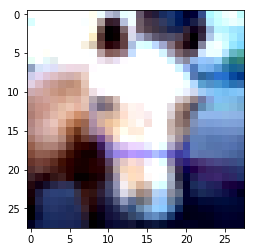

horse


In [7]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
imshow(a[0][0])
print(classes[a[1][0]])

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.utils import make_grid
import torchvision.utils as vutils
import matplotlib.animation as animation
from IPython.display import HTML

import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import pandas as pd
import copy
import time
import networkx as nx

from torch.autograd import Variable


In [9]:

device = 'cpu'
if torch.cuda.is_available() :
    device = 'cuda'

In [10]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    

Meanwhile, the decision of what computation operation to use sets a particular layer into convolution or average pooling or max pooing.

The 6 operations available for the controller are:

convolutions with filter sizes 3 × 3 and 5 × 5,

torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros')

depthwise-separable convolutions with filter sizes 3×3 and 5×5 (Chollet, 2017), 

class depthwise_separable_conv(nn.Module):

    def __init__(self, nin, kernels_per_layer, nout):
    
        super(depthwise_separable_conv, self).__init__()
        
        self.depthwise = nn.Conv2d(nin, nin * kernels_per_layer, kernel_size=3, padding=1, groups=nin)
        
        self.pointwise = nn.Conv2d(nin * kernels_per_layer, nout, kernel_size=1)

    def forward(self, x):
    
        out = self.depthwise(x)
        
        out = self.pointwise(out)
        
        return out
        
and max pooling and average pooling of kernel size 3 × 3:

torch.nn.MaxPool2d(kernel_size, stride=None, padding=0, dilation=1, return_indices=False, ceil_mode=False)

torch.nn.AvgPool2d(kernel_size, stride=None, padding=0, ceil_mode=False, count_include_pad=True, divisor_override=None)



In [11]:
def get_max_pool_layer(ksize):
    return nn.MaxPool2d(ksize).apply(weights_init)


def get_avg_pool_layer(ksize):
    return nn.AvgPool2d(ksize).apply(weights_init)

def get_conv_layer(in_lyr,out_lyr,ksize):
    seq_layer = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.Conv2d(in_lyr, out_lyr, ksize),
            nn.BatchNorm2d(out_lyr),
    )
    return seq_layer.apply(weights_init)

class depthwise_separable_conv(nn.Module):
    def __init__(self, nin, kernels_per_layer, nout):
        super(depthwise_separable_conv, self).__init__()
        self.depthwise = nn.Conv2d(nin, nin * kernels_per_layer, kernel_size=3, padding=1, groups=nin).apply(weights_init)
        self.pointwise = nn.Conv2d(nin * kernels_per_layer, nout, kernel_size=1).apply(weights_init)

    def forward(self, x):
        out = self.depthwise(x)
        out = self.pointwise(out)
        return out

def get_sep_layer(in_lyr,out_lyr,ksize):
    return depthwise_separable_conv(in_lyr,ksize,out_lyr)


In [12]:
# 1. Conv 3
# 2. Conv 5
# 3. Sep 3
# 4. Sep 5
# 5. MaxPool
# 6. AvgPool

out_features_shape = [10,24,32,64,128]
output_size = 10
num_actvn_fns = 6

def get_new_layer(actvn,x):
    ofsindex = 1
    actvn = actvn -1
#     print("Actvn -- "+str(actvn))
    
    out_features_shape[ofsindex] = x.shape[1]
    
    if actvn == 0:
        return get_conv_layer(x.shape[1],out_features_shape[ofsindex],3).to(device)
    if actvn == 1:
        return get_conv_layer(x.shape[1],out_features_shape[ofsindex],5).to(device)
    if actvn == 2:
        return get_sep_layer(x.shape[1],out_features_shape[ofsindex],3).to(device)
    if actvn == 3:
        return get_sep_layer(x.shape[1],out_features_shape[ofsindex],5).to(device)
    if actvn == 4:
        return get_max_pool_layer(3).to(device)
    if actvn == 5:
        return get_avg_pool_layer(3).to(device)
    return get_avg_pool_layer(3).to(device)

def get_out_layer(size):
    nlayer = nn.Sequential(
            nn.Linear(in_features=size[1]*size[2]*size[3], out_features=10),
            nn.LogSoftmax(),
        )
    return nlayer.apply(weights_init).to(device)

In [13]:
def concatzeroes(max_height,max_width,b):
    dim = 2
    pad_size_1 = int((max_height-b.shape[dim]) / 2)
    pad_size_2 = (max_height-b.shape[dim]) - pad_size_1
    b = F.pad(input=b, pad=(0, 0, pad_size_1, pad_size_2), mode='constant', value=0)

    dim = 3
    pad_size_1 = int((max_width-b.shape[dim]) / 2)
    pad_size_2 = (max_width-b.shape[dim]) - pad_size_1
    b = F.pad(input=b, pad=(pad_size_1, pad_size_2,0,0), mode='constant', value=0)
    
    return b

def downsizetensors(max_height,max_width,b):
    size = (max_height,max_width)
    return F.interpolate(b, size=size, mode='bilinear', align_corners=False)

def concatenate2(a,b,increase_size):
    if(increase_size):
        max_height = max(a.shape[2],b.shape[2])
        max_width = max(a.shape[3],b.shape[3])
        a = concatzeroes(max_height,max_width,a)
        b = concatzeroes(max_height,max_width,b)
        return torch.cat((a, b), 1)
    else:
        max_height = min(a.shape[2],b.shape[2])
        max_width = min(a.shape[3],b.shape[3])
        a = downsizetensors(max_height,max_width,a)
        b = downsizetensors(max_height,max_width,b)
        return torch.cat((a, b), 1)


def concatenate3(a,b,c,increase_size):
    if(increase_size):
        max_height = max(a.shape[2],b.shape[2],c.shape[2])
        max_width = max(a.shape[3],b.shape[3],c.shape[3])
        a = concatzeroes(max_height,max_width,a)
        b = concatzeroes(max_height,max_width,b)
        c = concatzeroes(max_height,max_width,c)
        return torch.cat((torch.cat((a, b), 1), c), 1)
    else:
        
        max_height = min(a.shape[2],b.shape[2],c.shape[2])
        max_width = min(a.shape[3],b.shape[3],c.shape[3])
        a = downsizetensors(max_height,max_width,a)
        b = downsizetensors(max_height,max_width,b)
        c = downsizetensors(max_height,max_width,c)
        return torch.cat((torch.cat((a, b), 1), c), 1)

In [14]:
class DAG(nn.Module):
    
    def __init__(self,num_layers):
        super(DAG, self).__init__()
        self.num_layers = num_layers
        self.myparameters = nn.ParameterList()
        self.dag = {}
        self.dag_calculated = {}
        self.loose_ends = []
        self.first_run = 0
        self.config = "0"
    def get_key(self,lnum):
        nconfig = self.config[0:int(3 * (lnum-1) )+1]
        key = ""
        for c in nconfig:
            key+=str(c)
        return key

    def initialize_param_grads(self):
        for p in self.myparameters:
            p.requires_grad = True
#         for lnum in range(1,self.num_layers+1):
# #             print(self.dag[get_key(lnum,config)])
#             for p in nn.ParameterList(self.dag[get_key(lnum,config)].parameters()):
#                 p.requires_grad = True
#         out_layer_key = get_key(self.num_layers,config)+"9"
#         for p in nn.ParameterList(self.dag[out_layer_key].parameters()):
#             p.requires_grad = True
        return

        
    #fac == forward acc to config
    def fac(self,x):
        self.loose_ends = []
        for i in range(1,self.num_layers+1):
            self.loose_ends.append(i)
            
        layer_activation = int(self.config[0])
        key = self.get_key(1)
        
        if key not in self.dag.keys():
            layer_t = get_new_layer(layer_activation,x)
            self.myparameters += nn.ParameterList(layer_t.parameters())
            self.dag[key] = layer_t
            for p in nn.ParameterList(layer_t.parameters()):
                p.requires_grad = True

            
        x = self.dag[key](x)
        self.dag_calculated[key] = x
#         print(x.shape)
        
        for lnum in range(2,self.num_layers+1):
#             print(lnum)
            key = self.get_key(lnum)
            prev_layer_1 = int(self.config[3*(lnum-1)+1 -3])
            prev_layer_2 = int(self.config[3*(lnum-1)+2 -3])
            layer_activation = int(self.config[3*(lnum-1)])
            
            if prev_layer_1 > lnum or prev_layer_2 > lnum:
                return None
            
            prev_layer_1_key = self.get_key(prev_layer_1)
            prev_layer_2_key = self.get_key(prev_layer_2)
            
            
            if key not in self.dag.keys():
                layer_t = get_new_layer(layer_activation,x)
                self.myparameters += nn.ParameterList(layer_t.parameters())
                self.dag[key] = layer_t
                for p in nn.ParameterList(layer_t.parameters()):
                    p.requires_grad = True
            x = self.dag[key](x)
            if prev_layer_1_key != prev_layer_2_key:
                x = concatenate3(self.dag_calculated[prev_layer_1_key],self.dag_calculated[prev_layer_2_key],x,0)
            else:
                x = concatenate2(self.dag_calculated[prev_layer_1_key],x,0)
            self.dag_calculated[key] = x
            
            
#             print(self.loose_ends)
            if self.loose_ends!=None and prev_layer_1 in self.loose_ends:
                self.loose_ends.remove(prev_layer_1)
            if self.loose_ends!=None and prev_layer_2 in self.loose_ends:
                self.loose_ends.remove(prev_layer_2)
#             print(self.loose_ends)
            
        num_loose_ends = len(self.loose_ends)
        if(num_loose_ends<=0):
            return None
        
        out = self.dag_calculated[self.get_key(self.loose_ends[0])]
        for i in range(1,num_loose_ends):
            out = concatenate2(out,self.dag_calculated[self.get_key(self.loose_ends[i])],0)
        
        out_layer_key = self.get_key(self.num_layers)+"9"
        if out_layer_key not in self.dag.keys():
            layer_t= get_out_layer(out.shape)
            self.dag[out_layer_key] = layer_t
            self.myparameters += nn.ParameterList(layer_t.parameters())
#         print(out.shape)
        out = out.view(out.shape[0],-1)
        self.dag_calculated[out_layer_key] = self.dag[out_layer_key](out)
        return self.dag_calculated[out_layer_key]

    def forward(self, x,config=None):
        return self.fac(x)

In [15]:
num_nodes = 6
dag_model = DAG(num_nodes)

In [16]:
lr = 0.0002
# Initialize BCELoss function
criterion = nn.NLLLoss()
optimizer = None


def model_train_loop(cnn_config):
    dag_model.config = cnn_config
    dag_model.initialize_param_grads()
    for epoch in range(10):
        # For each batch in the dataloader
        for i, data in enumerate(trainloader, 0):
            images, labels = data
            images, labels = images.to(device),labels.to(device)
            output = dag_model(images)
            if i==0 and epoch==0:
                optimizer = optim.Adam(dag_model.myparameters, lr=lr, betas=(0.5, 0.999))
            dag_model.zero_grad()
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
#         print(loss)
#             if i%100==0:
#                 print(((torch.sum(torch.argmax(output,1) == labels)).float()/labels.shape[0]).item())
#     #             print(loss.item())
        
    return Variable(((torch.sum(torch.argmax(output,1) == labels)).float()/labels.shape[0]), requires_grad=True)

In [17]:
model_train_loop([2, 1, 1, 2, 1, 1, 2, 1, 1, 2, 4, 1, 4, 4, 5, 4])

/opt/conda/lib/python3.6/site-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


tensor(0.6875, device='cuda:0', requires_grad=True)

## Controller Part ToDo : 
1. Define LSTM that generates 3*num_nodes -2 integers in the expected ranges and create configurations.

2. Write cost function and Back Propogation for the controller

nn.LSTM(input_dim, hidden_dim, n_layers, batch_first=True)

https://stackoverflow.com/questions/48302810/whats-the-difference-between-hidden-and-output-in-pytorch-lstm


In [18]:
from torch.distributions import Categorical
from torch.autograd import Variable

In [19]:
controller_num_epochs = 1
controller_optimizer = None

In [20]:
# class Controller(nn.Module):

#     def __init__(self):
#         super(Controller, self).__init__()
#         self.n_layers = 3
#         self.generated_config = []
#         self.policy_history = []

#         self.lstm1 = nn.LSTM(num_actvn_fns, num_nodes ,self.n_layers).to(device)
#         self.hidden1 = (torch.randn(self.n_layers, 1, num_nodes).to(device),torch.randn(self.n_layers, 1, num_nodes).to(device))
#         self.prev_out1 = torch.randn(1,1,num_nodes).to(device)

#         self.lstm2 = nn.LSTM(num_nodes, num_nodes ,self.n_layers).to(device)
#         self.hidden2 = (torch.randn(self.n_layers, 1, num_nodes).to(device),torch.randn(self.n_layers, 1, num_nodes).to(device))
#         self.prev_out2 = torch.randn(1, 1, num_nodes).to(device)
        
#         self.lstm3 = nn.LSTM(num_nodes, num_actvn_fns ,self.n_layers).to(device)
#         self.hidden3 = (torch.randn(self.n_layers, 1, num_actvn_fns).to(device),torch.randn(self.n_layers, 1, num_actvn_fns).to(device))
#         self.prev_out3 = torch.randn(1, 1, num_actvn_fns).to(device)
        
        
        
#     def update_controller(self,rewards):
#         self.zero_grad()
#         rewards = torch.Tensor(rewards)
#         loss = (torch.sum(torch.mul(torch.Tensor(self.policy_history), Variable(rewards,requires_grad=True)).mul(-1), -1))
#         loss.backward(retain_graph=True)
#         controller_optimizer.step()
#         print(loss)
#         return loss
    
#     def get_reward(self):
#         lent = len(self.generated_config)
#         lnum = int(lent/3) + 1
#         rewards = [0]*lent
#         if self.generated_config[lent-1] >= lnum :
#             rewards[lent-1] = 1000
#             self.update_controller(rewards)
#             return 1
# #         self.update_controller(rewards)
#         return 0
    
    
#     def forward(self):
#         self.generated_config = []
#         self.policy_history = []
#         self.zero_grad()
#         rewards = []
#         for i in range(3*num_nodes-2):
#             if i%3 ==0:
#                 out, self.hidden1 = self.lstm1(self.prev_out3, self.hidden1)
#                 out = F.sigmoid(out)
#                 self.prev_out1 = out
#                 probs = Categorical(out)
#                 action = probs.sample()
#                 self.policy_history.append(Variable(probs.log_prob(action),requires_grad=True))
#                 self.generated_config.append(action.item())
#             if i%3 ==1:
#                 out, self.hidden2 = self.lstm2(self.prev_out1, self.hidden2)
#                 out = F.sigmoid(out)
#                 self.prev_out2 = out
#                 probs = Categorical(out)
#                 action = probs.sample()
#                 self.policy_history.append(Variable(probs.log_prob(action),requires_grad=True))
#                 self.generated_config.append(torch.argmax(out).item())
#                 if self.get_reward():
#                     return None
#                 return
#             if i%3 ==2:
#                 out, self.hidden3 = self.lstm3(self.prev_out2, self.hidden3)
#                 out = F.sigmoid(out)
#                 self.prev_out3 = out
#                 probs = Categorical(out)
#                 action = probs.sample()
#                 self.policy_history.append(Variable(probs.log_prob(action),requires_grad=True))
#                 self.generated_config.append(torch.argmax(out).item())
#                 if self.get_reward():
#                     return None
#         return self.generated_config

In [21]:
class Controller(nn.Module):

    def __init__(self):
        super(Controller, self).__init__()
        self.n_layers = 3
        self.generated_config = []
        self.policy_history = []

        self.lstm = nn.LSTM(num_actvn_fns, num_nodes ,self.n_layers).to(device)
        self.hidden = (torch.randn(self.n_layers, 1, num_nodes).to(device),torch.randn(self.n_layers, 1, num_nodes).to(device))
        self.prev_out = torch.randn(1,1,num_nodes).to(device)

    def update_controller(self,rewards):
        self.zero_grad()
        rewards = torch.Tensor(rewards)
        loss = (torch.sum(torch.mul(torch.Tensor(self.policy_history), Variable(rewards,requires_grad=True)).mul(-1), -1))
        loss.backward(retain_graph=True)
        controller_optimizer.step()
#         print(loss)
        return loss
    
    def get_reward(self):
        lent = len(self.generated_config)
        lnum = int(lent/3) + 1
        rewards = [0]*lent
        if (lent-1)%3 == 0:
            if self.generated_config[lent-1] == 0 or self.generated_config[lent-1] > 6:
                rewards[lent-1] = -1
                self.update_controller(rewards)
                return 1
        if (lent-2)%3 == 0:
            if self.generated_config[lent-1] == 0 or self.generated_config[lent-1] >= lnum:
                rewards[lent-1] = -1
                self.update_controller(rewards)
                return 1
        if (lent)%3 == 0:
            if self.generated_config[lent-1] == 0 or self.generated_config[lent-1] >= lnum:
                rewards[lent-1] = -1
                self.update_controller(rewards)
                return 1
#         self.update_controller(rewards)
        return 0
    
    
    def forward(self):
        self.generated_config = []
        self.policy_history = []
        self.zero_grad()
        rewards = []
        for i in range(3*num_nodes-2):
            out, self.hidden = self.lstm(self.prev_out, self.hidden)
            out = F.sigmoid(out)
            self.prev_out = out
            probs = Categorical(out)
            action = probs.sample()
            self.policy_history.append(Variable(probs.log_prob(action),requires_grad=True))
            self.generated_config.append(torch.argmax(out).item())
            if self.get_reward():
                return None
        return self.generated_config

In [22]:
controller_model = Controller().to(device)
controller_optimizer = optim.Adam(controller_model.parameters(), lr=0.1, betas=(0.5, 0.999))
controller_model()

/opt/conda/lib/python3.6/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [23]:
controller_num_epochs = 100000
for controller_epoch in range(controller_num_epochs):
    config = controller_model()
    if config!=None:
        print(config)
        print(model_train_loop(config))